In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# compile NMODL files that may be needed
# TODO: Write a python function for this that do this in /tmp/
!cd mod && nrnivmodl && cd -

/home/tone/work/BrainSignals/notebooks/Ch-6/mod
Mod files: "./CaDynamics_E2.mod" "./Ca_HVA_frozen.mod" "./Ca_HVA.mod" "./Ca_LVAst_frozen.mod" "./Ca_LVAst.mod" "./exp2synI.mod" "./Ih_frozen.mod" "./Ih_linearized_v2_frozen.mod" "./Ih_linearized_v2.mod" "./Ih.mod" "./Im_frozen.mod" "./Im.mod" "./K_Pst_frozen.mod" "./K_Pst.mod" "./K_Tst_frozen.mod" "./K_Tst.mod" "./Nap_Et2_frozen.mod" "./Nap_Et2_linearized.mod" "./Nap_Et2.mod" "./NaTa_t_frozen.mod" "./NaTa_t.mod" "./NaTs2_t_frozen.mod" "./NaTs2_t.mod" "./SK_E2_frozen.mod" "./SK_E2.mod" "./SKv3_1_frozen.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
/home/tone/work/BrainSignals/notebooks/Ch-6


In [3]:
import os
from parameters import ParameterSpace, ParameterSet, ParameterRange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
import scipy.signal as ss
from example_network_parameters import (networkParameters, population_names,
                                        population_sizes)
from lfpykernels import KernelApprox, GaussCylinderPotential
import example_network_methods as methods
import example_network_parameters as params
from plotting import remove_axis_junk
import scipy.stats as st
from copy import deepcopy
from plotting import draw_lineplot, annotate_subplot
import plotting
from lfpykit import CurrentDipoleMoment, LaminarCurrentSourceDensity
import json
import hashlib
import pandas as pd
import seaborn as sb
from time import time
import neuron

In [4]:
plt.rcParams.update(plotting.rcParams)
golden_ratio = plotting.golden_ratio
figwidth = plotting.figwidth # inches

In [5]:
# use custom color scheme
# default_cycler = plt.cycler(color=plotting.senkcolors[3:])
# plt.rc('axes', prop_cycle=default_cycler)

In [6]:
PS0 = ParameterSpace('PS0.txt')
PS1 = ParameterSpace('PS1.txt')
PS2 = ParameterSpace('PS2.txt')

In [7]:
neuron.load_mechanisms('mod')

True

In [8]:
TRANSIENT = 2000
dt = networkParameters['dt']
tau = 100  # max time lag relative to spike for kernel predictions
tau_trunc = 25 # max time lag for shown in plot

In [9]:
# ss.welch/plt.mlab.psd/csd settings
Fs = 1000 / dt
NFFT = 1024 * 2
noverlap = 768 * 2
detrend = False

In [10]:
# low-pass filter settings
N = 2  # filter order
rp = 0.1  # ripple in passband (dB)
rs = 40.  # minimum attenuation required in the stop band (dB)
fc = 100.  # critical frequency (Hz)
btype = 'lp'  # filter type

# filter coefficients on 'sos' format
sos_ellip = ss.ellip(N=N, rp=rp, rs=rs, Wn=fc, btype=btype, fs=Fs, output='sos')

In [11]:
# flag; if True, use the mean membrane potential per compartment for kernel predictions 
perseg_Vrest = False

In [12]:
# downsample signals for plots to resolution dt * decimate_ratio
decimate_ratio = 4

In [13]:
# figure out which real LFP to compare with
for pset in PS1.iter_inner():
    weight_EE = pset['weight_EE']
    weight_IE = pset['weight_IE']
    weight_EI = pset['weight_EI']
    weight_II = pset['weight_II']
    weight_scaling = pset['weight_scaling']
    pset_0 = ParameterSet(dict(weight_EE=weight_EE,
                               weight_IE=weight_IE,
                               weight_EI=weight_EI,
                               weight_II=weight_II,
                               weight_scaling=weight_scaling,
                               n_ext=PS0['n_ext'].value))
    js_0 = json.dumps(pset_0, sort_keys=True).encode()
    md5_0 = hashlib.md5(js_0).hexdigest()
    OUTPUTPATH_REAL = os.path.join('output', md5_0)

    break
print(f'comparing with ground truth dataset: {OUTPUTPATH_REAL}')

comparing with ground truth dataset: output/adb947bfb931a5a8d09ad078a6d256b0


In [14]:
# compute firing rate time series of "real" network (as spikes per time bin of width dt)
nu_X = dict()
tstop = networkParameters['tstop']
bins = (np.arange(0, tstop / dt + 2)
        * dt - dt / 2)
with h5py.File(os.path.join(OUTPUTPATH_REAL, 'spikes.h5'), 'r') as f:
    for i, X in enumerate(params.population_names):
        hist = np.histogram(np.concatenate(f[X]['times']), bins=bins)[0]
        nu_X[X] = hist.astype(float)

In [15]:
# drop 'biophys':'lin' 
PS2['biophys'] = ParameterRange(['frozen'])
PS2

{'weight_EE': ParameterRange([0.00015]),
 'weight_IE': ParameterRange([0.000125]),
 'weight_EI': ParameterRange([0.0045]),
 'weight_II': ParameterRange([0.002]),
 'weight_scaling': ParameterRange([1.0]),
 'biophys': ParameterRange(['frozen']),
 'n_ext': ParameterRange([[465, 160]]),
 't_E': ParameterRange([200.0]),
 't_I': ParameterRange([400.0]),
 'g_eff': ParameterRange([True]),
 'perseg_Vrest': ParameterRange([False])}

In [16]:
PS1['biophys'] = ParameterRange(['frozen'])
PS1['g_eff'] = ParameterRange([True])
PS1

{'weight_EE': ParameterRange([0.00015]),
 'weight_IE': ParameterRange([0.000125]),
 'weight_EI': ParameterRange([0.0045]),
 'weight_II': ParameterRange([0.002]),
 'weight_scaling': ParameterRange([1.0]),
 'biophys': ParameterRange(['frozen']),
 'i_syn': ParameterRange([True]),
 'n_ext': ParameterRange([[465, 160]]),
 'g_eff': ParameterRange([True]),
 'perseg_Vrest': ParameterRange([False])}

In [17]:
# Compute spike-LFP and spike-dipole moment kernel approximations using the KernelApprox class

# kernel container
H_YX_pred = dict()
H_YX_pred_times = pd.DataFrame(columns=['step', 'time_s'])
for k, pset in enumerate(PS2.iter_inner()):
    # sorted json dictionary
    js = json.dumps(pset, sort_keys=True).encode()
    md5 = hashlib.md5(js).hexdigest()

    # tic toc
    tic = time()
    
    # parameters
    weight_EE = pset['weight_EE']
    weight_IE = pset['weight_IE']
    weight_EI = pset['weight_EI']
    weight_II = pset['weight_II']
    weight_scaling = pset['weight_scaling']
    biophys = pset['biophys']
    n_ext = pset['n_ext']
    g_eff = pset['g_eff']

    t_X = TRANSIENT  # presynaptic activation time

    # define biophysical membrane properties
    if biophys == 'pas':
        custom_fun = [methods.set_pas_hay2011, methods.make_cell_uniform]
    elif biophys == 'frozen':
        custom_fun = [methods.set_frozen_hay2011, methods.make_cell_uniform]
    elif biophys == 'frozen_no_Ih':
        custom_fun = [methods.set_frozen_hay2011_no_Ih, methods.make_cell_uniform]
    elif biophys == 'lin':
        custom_fun = [methods.set_Ih_linearized_hay2011, methods.make_cell_uniform]
    else:
        raise NotImplementedError

    # synapse max. conductance (function, mean, st.dev., min.):
    weights = np.array([[weight_EE, weight_IE],
                        [weight_EI, weight_II]]) * weight_scaling

    # class RecExtElectrode/PointSourcePotential parameters:
    electrodeParameters = params.electrodeParameters.copy()
    for key in ['r', 'n', 'N', 'method']:
        del electrodeParameters[key]

    # Not using RecExtElectrode class as we anyway average potential in
    # space for each source element. 

    # Predictor assuming planar disk source elements convolved with Gaussian
    # along z-axis
    gauss_cyl_potential = GaussCylinderPotential(
        cell=None,
        z=electrodeParameters['z'],
        sigma=electrodeParameters['sigma'],
        R=params.populationParameters['pop_args']['radius'],
        sigma_z=params.populationParameters['pop_args']['scale'],
        )

    # set up recording of current dipole moments.
    current_dipole_moment = CurrentDipoleMoment(cell=None)

    # Compute average firing rate of presynaptic populations X
    mean_nu_X = methods.compute_mean_nu_X(params, OUTPUTPATH_REAL,
                                     TRANSIENT=TRANSIENT)

    # tic-tac
    tac = time()
    H_YX_pred_times_pset = pd.DataFrame(data={'step': 'setup', 'time_s': tac-tic}, index=[0])
        
    # kernel container
    H_YX_pred[md5] = dict()

    for i, (X, N_X) in enumerate(zip(params.population_names,
                                     params.population_sizes)):
        for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                     params.population_sizes,
                                                     params.morphologies)):
            # tic tac
            tic = time()
            
            # Extract median soma voltages from actual network simulation and
            # assume this value corresponds to Vrest.
            if not perseg_Vrest:
                with h5py.File(os.path.join(OUTPUTPATH_REAL, 'somav.h5'
                                            ), 'r') as f:
                    Vrest = np.median(f[Y][()][:, TRANSIENT:])
            else:  # perseg_Vrest == True
                with h5py.File(os.path.join(OUTPUTPATH_REAL, 'vmem.h5'
                                            ), 'r') as f:
                    Vrest = np.median(f[Y][()][:, TRANSIENT:], axis=-1)

            cellParameters = deepcopy(params.cellParameters)
            cellParameters.update(dict(
                morphology=morphology,
                custom_fun=custom_fun,
                custom_fun_args=[dict(Vrest=Vrest), dict(Vrest=Vrest)],
            ))
            
            # some inputs must be lists
            synapseParameters = [
                dict(weight=weights[ii][j],
                     syntype='Exp2Syn',
                     **params.synapseParameters[ii][j])
                for ii in range(len(params.population_names))]
            synapsePositionArguments = [
                params.synapsePositionArguments[ii][j]
                for ii in range(len(params.population_names))]

            # Create kernel approximator object
            kernel = KernelApprox(
                X=params.population_names,
                Y=Y,
                N_X=np.array(params.population_sizes),
                N_Y=N_Y,
                C_YX=np.array(params.connectionProbability[i]),
                cellParameters=cellParameters,
                populationParameters=params.populationParameters['pop_args'],
                multapseFunction=params.multapseFunction,
                multapseParameters=[params.multapseArguments[ii][j] for ii in range(len(params.population_names))],
                delayFunction=params.delayFunction,
                delayParameters=[params.delayArguments[ii][j] for ii in range(len(params.population_names))],
                synapseParameters=synapseParameters,
                synapsePositionArguments=synapsePositionArguments,
                extSynapseParameters=params.extSynapseParameters,
                nu_ext=1000. / params.netstim_interval,
                n_ext=n_ext[j],
                nu_X=mean_nu_X,
            )
            
            # tic-tac
            tac = time()
            H_YX_pred_times_pset = pd.concat([
                H_YX_pred_times_pset,
                pd.DataFrame(data={'step': 'create', 'time_s': tac-tic}, index=[0])], ignore_index=True)

            # make kernel predictions
            H_YX_pred[md5]['{}:{}'.format(Y, X)] = kernel.get_kernel(
                probes=[gauss_cyl_potential, current_dipole_moment],
                Vrest=Vrest, dt=dt, X=X, t_X=t_X, tau=tau,
                g_eff=g_eff,
            )
            
            # tic-tac-toc
            toc = time()
            H_YX_pred_times_pset = pd.concat([
                H_YX_pred_times_pset,
                pd.DataFrame(data={'step': 'simulate', 'time_s': toc-tac}, index=[0])], ignore_index=True)

    H_YX_pred_times_pset = H_YX_pred_times_pset.groupby('step', as_index=False).agg({'time_s': 'sum'})
    H_YX_pred_times = pd.concat([H_YX_pred_times, H_YX_pred_times_pset], ignore_index=True)

In [18]:
# Compute reconstructed signals as the sum over convolutions
# phi(r, t) = sum_X sum_Y (nu_X*H_YX)(r, t)
# using kernels obtained either via the hybrid scheme and direct method
all_kernel_predictions = []
for j, (fname, ylabel, probe) in enumerate(zip(
    ['RecExtElectrode.h5', 'CurrentDipoleMoment.h5'],
    [r'$V_\mathrm{e}$', r'$\mathbf{P}$'],
    ['GaussCylinderPotential', 'CurrentDipoleMoment'],
    )):
       
    with h5py.File(os.path.join(OUTPUTPATH_REAL, fname),
                   'r') as f:
        data = f['data'][()]
                
    # compare biophysical variants using predicted kernels
    kernel_predictions = []  # container
    for k, pset in enumerate(PS2.iter_inner()):
        # sorted json dictionary
        js = json.dumps(pset, sort_keys=True).encode()
        md5 = hashlib.md5(js).hexdigest()

        label = ''
        for h, (key, value) in enumerate(pset.items()):
            if key.rfind('weight') >= 0 or key.rfind('n_ext') >= 0 or key.rfind('i_syn') >= 0 or key.rfind('t_E') >= 0 or key.rfind('t_I') >= 0 or key.rfind('perseg_Vrest') >= 0:
                continue
            if h > 5:
                label += '\n'
            label += '{}:{}'.format(key, value)

        prediction_label = r'$\sum_X \sum_Y \nu_X \ast \hat{H}_\mathrm{YX}$' + '\n' + label
        
        data = None
        for i, (X, N_X) in enumerate(zip(population_names,
                                         population_sizes)):
            for Y in population_names:
                if data is None:
                    data = np.zeros((H_YX_pred[md5]['{}:{}'.format(Y, X)][probe].shape[0],
                                     nu_X[X].size))
                for h, h_YX in enumerate(H_YX_pred[md5]['{}:{}'.format(Y, X)][probe]):
                    data[h, :] = data[h, :] + np.convolve(nu_X[X], h_YX,
                                                          'same')

        kernel_predictions.append((prediction_label, data))

    all_kernel_predictions.append(kernel_predictions)

## Plot

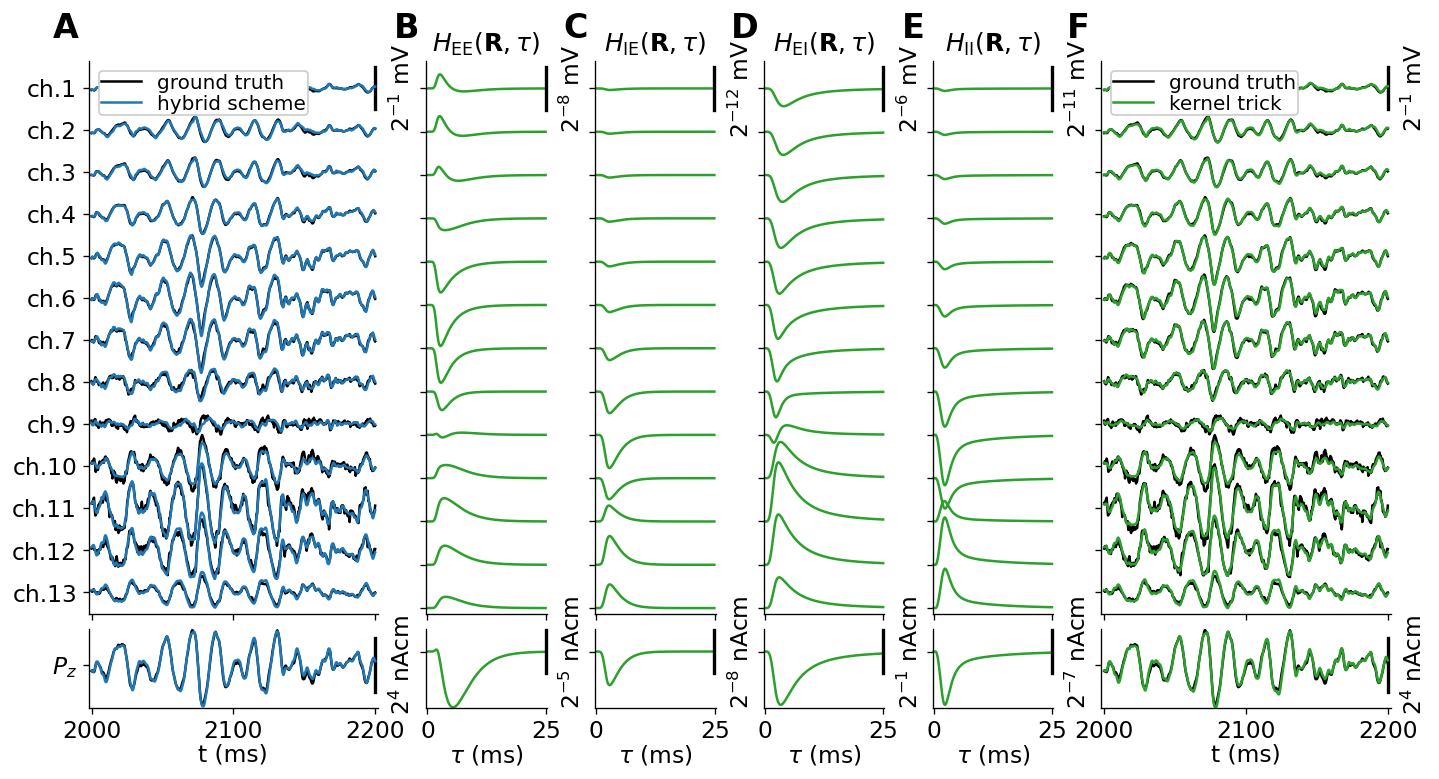

In [19]:
# Plot hybrid-scheme vs. ground truth data

# create figure    
fig = plt.figure(figsize=(figwidth, figwidth / 2))
fig.subplots_adjust(wspace=0.4)
# create subplots
ncols = 8
gs = GridSpec(7, ncols)
axes = np.array([[None] * 6] * 2, dtype=object)
for i in range(2):
    if i == 0:
        axes[i, 0] = fig.add_subplot(gs[:6, :2])
    else:
        axes[i, 0] = fig.add_subplot(gs[6, :2], sharex=axes[0, 0])

annotate_subplot(axes[0, 0], ncols=4, nrows=3, letter='A', linear_offset=0.02)
    
# compare summed extracellular signals
for j, (fname, ylabel, probe, unit, vlimround) in enumerate(zip(
    ['RecExtElectrode.h5', 'CurrentDipoleMoment.h5'],
    [r'$V_\mathrm{e}$', r'$\mathbf{P}$'],
    ['GaussCylinderPotential', 'CurrentDipoleMoment'],
    ['mV', 'nAµm'],
    [2**-1, 2**4])):

    if probe == 'CurrentDipoleMoment':
        scaling = 1E-4  # nAum --> nAcm unit conversion
        unit = 'nAcm'
    else:
        scaling = 1

    # ground truth
    with h5py.File(os.path.join(OUTPUTPATH_REAL, fname),
                   'r') as f:
        data = f['data'][()]
        if probe == 'CurrentDipoleMoment':
            data = data[-1, :].reshape((1, data.shape[1]))
        
        label = 'ground truth'
        ax = axes[j, 0]
        draw_lineplot(ax,
                        ss.decimate(data['imem'], q=decimate_ratio,
                                    zero_phase=True) * scaling,
                        dt=dt * decimate_ratio,
                        T=(TRANSIENT, TRANSIENT+200),
                        scaling_factor=1.,
                        vlimround=vlimround,
                        label=label,
                        scalebar=True,
                        unit=unit,
                        ylabels=True,
                        color='k',
                        ztransform=True
                        )
        if j == 0:
            # ax.set_title(label)
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_ylabel(ylabel)
        # ax.set_ylabel('')
        

    for i, pset in enumerate(PS1.iter_inner()):
        js = json.dumps(pset, sort_keys=True).encode()
        md5 = hashlib.md5(js).hexdigest()
        
        OUTPUTPATH = os.path.join('output', md5)
        with h5py.File(os.path.join(OUTPUTPATH, fname), 'r') as f:
            data = f['data'][()]

        if probe == 'CurrentDipoleMoment':
            data = data[-1, :].reshape((1, data.shape[1]))
            
        ax = axes[j, i]
        '''label = ''
        for h, (key, value) in enumerate(pset.items()):
            if key.rfind('weight') >= 0 or key.rfind('n_ext') >= 0 or key.rfind('i_syn') >= 0 or key.rfind('perseg_Vrest') >= 0:
                continue
            if h > 5:
                label += '\n'
            label += '{}:{}'.format(key, value)
        '''
        label = 'hybrid scheme'

        draw_lineplot(ax,
                      ss.decimate(data['imem'], q=decimate_ratio,
                                  zero_phase=True) * scaling,
                      dt=dt * decimate_ratio,
                      T=(TRANSIENT, TRANSIENT+200),
                      scaling_factor=1.,
                      vlimround=vlimround,
                      label=label,
                      scalebar=False,
                      unit=True,
                      ylabels=True,
                      color=f'C{i}',
                      ztransform=True
                      )
        if probe == 'CurrentDipoleMoment':
            ax.set_yticklabels(['$P_z$'])

        if j == 0:
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.legend(loc=2)
        # if i > 0:
        #     plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel('')



#######################################################################################
# predicted kernels
# axes = np.array([[None] * 4] * 2, dtype=object)
for i in range(2):
    for j in range(4):
        if i == 0:
            if j == 0:
                axes[i, j + 1] = fig.add_subplot(gs[:6, j + 2])
            else:
                axes[i, j + 1] = fig.add_subplot(gs[:6, j + 2], sharey=axes[0, 1], sharex=axes[0, 1])
        else:
            if j == 0:
                axes[i, j + 1] = fig.add_subplot(gs[6, j + 2], sharex=axes[0, 1])
            else:
                axes[i, j + 1] = fig.add_subplot(gs[6, j + 2], sharey=axes[1, 1], sharex=axes[0, 1])

for k, pset in enumerate(PS2.iter_inner()):
    # sorted json dictionary
    js = json.dumps(pset, sort_keys=True).encode()
    md5 = hashlib.md5(js).hexdigest()

    for i, (X, t, N_X) in enumerate(zip(population_names,
                                        [pset['t_E'], pset['t_I']],
                                        population_sizes)):
        inds = (np.arange(0, tau_trunc // dt + 1)
                + t // dt).astype(int)
        for j, Y in enumerate(population_names):
            for h, (unit, label) in enumerate(
                    zip(['mV', 'nAµm'],
                        ['GaussCylinderPotential', 'CurrentDipoleMoment'])):
                title = (
                    r'$H_\mathrm{%s %s}(\mathbf{R}, \tau)$'
                    % (Y, X)
                    )
                
                ax = axes[h, i * 2 + j + 1]
                H_YX = H_YX_pred[md5]['{}:{}'.format(Y, X)][label][:, int(tau // dt):int((tau + tau_trunc) // dt)]

                # deal with current dipole moment
                if label == 'CurrentDipoleMoment':
                    scaling = 1E-4  # nAum --> nAcm unit conversion
                    unit = 'nAcm'
                    H_YX = H_YX[-1, :].reshape((1, H_YX.shape[1])) # show only z-component
                else:
                    scaling = 1
                
                draw_lineplot(
                    ax,
                    H_YX * scaling,
                    dt=dt,
                    T=(0, tau),
                    scaling_factor=1.,
                    vlimround=None,
                    label=f"biophys:{pset['biophys']}",
                    scalebar=True if k == 0 else False,
                    unit=unit,
                    ylabels=True,
                    color=f'C{k + PS1.num_conditions() + PS2.num_conditions()}',
                    ztransform=False
                    )
                if label == 'CurrentDipoleMoment':
                    ax.set_yticklabels(['$P_{}$'.format(x) for x in 'z'])
                if h == 0:
                    ax.set_title(title)
                    ax.set_xlabel('')
                    plt.setp(ax.get_xticklabels(), visible=False)
                if (i * 2 + j) == 0:
                    ax.set_ylabel('')
                else:
                    ax.set_ylabel('')
                plt.setp(ax.get_yticklabels(), visible=False)
                if h == 1:
                    ax.set_xlabel(r'$\tau$ (ms)')
                else:
                    plt.setp(ax.get_xticklabels(), visible=False)

# axes[0, 1].legend(loc=1)
for i, ax in enumerate(axes[0, 1:5]):
    annotate_subplot(ax, ncols=8, nrows=3, letter='BCDE'[i], linear_offset=0.02)



###############################################################################
# plot kernel predictions

for i in range(2):
    if i == 0:
        axes[i, -1] = fig.add_subplot(gs[:6, 6:], sharey=axes[0, 0], sharex=axes[0, 0])
    else:
        axes[i, -1] = fig.add_subplot(gs[6, 6:], sharey=axes[1, 0], sharex=axes[0, 0])


annotate_subplot(axes[0, -1], ncols=4, nrows=3, letter='F', linear_offset=0.02)
    
# compare summed extracellular signals
for j, (fname, ylabel, probe, unit, vlimround) in enumerate(zip(
    ['RecExtElectrode.h5', 'CurrentDipoleMoment.h5'],
    [r'$V_\mathrm{e}$', r'$\mathbf{P}$'],
    ['GaussCylinderPotential', 'CurrentDipoleMoment'],
    ['mV', 'nAµm'],
    [2**-1, 2**4])):

    if probe == 'CurrentDipoleMoment':
        scaling = 1E-4  # nAum --> nAcm unit conversion
        unit = 'nAcm'
    else:
        scaling = 1
        
    with h5py.File(os.path.join(OUTPUTPATH_REAL, fname),
                   'r') as f:
        data = f['data'][()]
        if probe == 'CurrentDipoleMoment':
            data = data[-1, :].reshape((1, data.shape[1]))

        ax = axes[j, -1]
        label = 'ground truth'
        draw_lineplot(ax,
                        ss.decimate(data['imem'], q=decimate_ratio,
                                    zero_phase=True) * scaling,
                        dt=dt * decimate_ratio,
                        T=(TRANSIENT, TRANSIENT+200),
                        scaling_factor=1.,
                        vlimround=vlimround,
                        label=label,
                        scalebar=True,
                        unit=unit,
                        ylabels=True,
                        color='k',
                        ztransform=True
                        )
        if j == 0:
            # ax.set_title(label)
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), visible=False)
        # ax.set_ylabel(ylabel)
        ax.set_ylabel('')
    
        
    # compare biophysical variants using predicted kernels
    for k, pset in enumerate(PS2.iter_inner()):

        # sorted json dictionary
        js = json.dumps(pset, sort_keys=True).encode()
        md5 = hashlib.md5(js).hexdigest()

        # data = None
        # ax = axes[j, k + PS2.num_conditions()]

        '''label = ''
        for h, (key, value) in enumerate(pset.items()):
            if key.rfind('weight') >= 0 or key.rfind('n_ext') >= 0 or key.rfind('i_syn') >= 0 or key.rfind('t_E') >= 0 or key.rfind('t_I') >= 0 or key.rfind('perseg_Vrest') >= 0:
                continue
            if h > 5:
                label += '\n'
            label += '{}:{}'.format(key, value)
        '''
        label = 'kernel trick'
        # title = 'ground truth vs.\n' + r'$\sum_X \sum_Y \left( \nu_X \ast \hat{H}_\mathrm{YX} \right) (\mathbf{R}, t)$'
        
        if probe == 'CurrentDipoleMoment':
            scaling = 1E-4  # nAum --> nAcm unit conversion
            unit = 'nAcm'
        else:
            scaling = 1

        prediction_label, data = all_kernel_predictions[j][k]
        if probe == 'CurrentDipoleMoment':
            data = data[-1, :].reshape((1, data.shape[1]))

        draw_lineplot(ax,
                      ss.decimate(data, q=decimate_ratio,
                                  zero_phase=True) * scaling,
                      dt=dt * decimate_ratio,
                      T=(TRANSIENT, TRANSIENT+200),
                      scaling_factor=1.,
                      vlimround=vlimround,
                      label=label,
                      scalebar=False,
                      unit=unit,
                      ylabels=True,
                      color=f'C{2}',
                      ztransform=True
                      )

        if probe == 'CurrentDipoleMoment':
            ax.set_yticklabels(['$P_z$'])

        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel('')
        if j == 0:
            # ax.set_title(title)
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.legend(loc=2)

fig.savefig('Figure_6.pdf', bbox_inches='tight', pad_inches=0)


In [20]:
nu_X

{'E': array([0., 0., 0., ..., 1., 1., 0.]),
 'I': array([0., 0., 0., ..., 0., 0., 0.])}

In [25]:
pathways = ['E:E', 'I:E', 'E:I', 'I:I']

for pathway in pathways:
    p = H_YX_pred[md5][pathway]['CurrentDipoleMoment']
    print(p.shape)



(3, 3201)
(3, 3201)
(3, 3201)
(3, 3201)
